# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import csv
import requests
import nltk
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
nltk.download('punkt') # Untuk tokenisasi
nltk.download('punkt_tab') # Untuk tokenisasi
nltk.download('stopwords') # Untuk stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading Dataset

In [2]:
reviews_df = pd.read_csv("reviews.csv")
reviews_df.head()

,userName,score,at,content
0,Pengguna Google,3,2025-03-21 18:10:11,ongkir udh mahal ke aceh
1,Pengguna Google,1,2025-03-21 17:58:33,"Fake application, this application provide sel..."
2,Pengguna Google,1,2025-03-21 17:54:03,driver kurir instant lama pick barangnya
3,Pengguna Google,5,2025-03-21 17:36:58,toko pedia selalu membantu dalam belanja onlin...
4,Pengguna Google,5,2025-03-21 17:30:04,bismillah coba download 😁


In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  3357 non-null   object
 1   score     3357 non-null   int64 
 2   at        3357 non-null   object
 3   content   3357 non-null   object
dtypes: int64(1), object(3)
memory usage: 105.0+ KB


In [4]:
reviews_df.isnull().sum()

userName    0
score       0
at          0
content     0
dtype: int64

In [5]:
reviews_df.duplicated().sum()

np.int64(0)

# Preprocessing Text

### Cleaning Text

In [6]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'[^\w\s]', '', text) 
 
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ')
    return text

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
reviews_df['text_clean'] = reviews_df['content'].apply(cleaningText)

### Case Folding Text

In [7]:
def casefoldingText(text): 
    text = text.lower()
    return text

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
reviews_df['text_casefoldingText'] = reviews_df['text_clean'].apply(casefoldingText)

### Hapus Slang Words

In [8]:
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "sangat",  
    "maks": "maksimal", "ngga": "tidak", "gk": "tidak", "ga": "tidak", "uda": "sudah", "udah": "sudah", "udh": "sudah",  
    "jga": "juga", "jg": "juga", "lemot": "lambat", "pake": "pakai", "kl": "kalau", "klo": "kalau", "dpt": "dapat",  
    "kpd": "kepada", "jd": "jadi", "tokped": "tokopedia", "yg": "yang", "knp": "kenapa", "jls": "jelas", "tdk": "tidak",  
    "sy": "saya", "gw": "saya", "gue": "saya", "loe": "kamu", "lu": "kamu", "elo": "kamu", "trs": "terus", "td": "tadi",  
    "skrg": "sekarang", "sbnrnya": "sebenarnya", "bs": "bisa", "gmn": "gimana", "kmrn": "kemarin", "btw": "ngomong-ngomong",  
    "tp": "tapi", "trm": "terima", "dgn": "dengan", "sm": "sama", "smpe": "sampai", "ampun": "tidak sanggup", "pdhl": "padahal",  
    "bnyk": "banyak", "plis": "tolong", "brp": "berapa", "dr": "dari", "tdr": "tidur", "dmn": "dimana", "spt": "seperti",  
    "cm": "cuma", "tggu": "tunggu", "cb": "coba", "blm": "belum", "swt": "kesal", "mlh": "malah", "msh": "masih", "bkn": "bukan",  
    "bt": "kesal", "d": "di", "aj": "aja", "mnrt": "menurut", "ok": "oke", "mnt": "minta", "org": "orang", "bgs": "bagus",  
    "krn": "karena", "hrus": "harus", "sdh": "sudah", "smw": "semua", "trmksh": "terima kasih", "brngkt": "berangkat",  
    "stlh": "setelah", "sblm": "sebelum", "gak": "tidak", "sampe": "sampai", "banget": "sangat", "bngt": "sangat", "gaada": "tanpa", "jd": "jadi", "jdi": "jadi",

    # Slang words terkait jual-beli  
    "cod": "bayar di tempat", "dp": "uang muka", "freeongkir": "gratis ongkir", "grt": "gratis", "ongkir": "ongkos kirim",  
    "retur": "pengembalian barang", "resi": "nomor resi", "rekber": "rekening bersama", "tf": "transfer", "cicil": "pembayaran cicilan",  
    "brg": "barang", "dsb": "dan sebagainya", "stok": "persediaan", "sold": "terjual", "ori": "original", "kw": "tiruan",  
    "sisa": "tersisa", "laku": "terjual", "bo": "buka order", "po": "pre-order", "dpn": "di depan", "bnib": "baru dalam kotak",  
    "bnob": "baru tanpa kotak", "nego": "negosiasi", "nego tipis": "negosiasi harga kecil", "net": "harga pas", "murce": "murah sekali",  
    "jlsgan": "jelas gan", "fast resp": "respon cepat", "slow resp": "respon lambat", "gan": "bro", "sis": "kakak", "ts": "penjual",  
    "rek": "rekening", "cs": "customer service", "kurir": "pengantar barang", "dropship": "penjualan tanpa stok", "grosir": "jual dalam jumlah banyak",  
    "ecer": "jual satuan", "restock": "stok ulang", "reseller": "penjual kembali", "bukti tf": "bukti transfer", "batalin": "batalkan",  
    "refund": "pengembalian uang", "klaim": "pengajuan hak", "complain": "keluhan", "klaim garansi": "pengajuan jaminan", "blacklist": "daftar hitam",  
    "banned": "dilarang", "expired": "kadaluarsa", "packing": "pengemasan", "spek": "spesifikasi", "mod": "modifikasi",  
    "cek out": "selesai belanja", "cart": "keranjang belanja", "wishlist": "daftar keinginan", "top up": "isi ulang saldo",  
    "voucher": "kupon diskon", "diskon": "potongan harga", "promo": "promosi", "cashback": "pengembalian uang", "limit": "batas",  
    "saldo": "jumlah uang dalam akun", "event": "acara promosi", "bundling": "paket produk", "unbox": "membuka paket",  
    "rekber": "rekening bersama", "pending": "tertunda", "approve": "disetujui", "reject": "ditolak", "deliv": "pengiriman",  
    "fast deliv": "pengiriman cepat", "antri": "dalam antrean", "cancel": "batal", "confirm": "konfirmasi", "onproses": "sedang diproses",  
    "done": "selesai", "valid": "sah", "invalid": "tidak sah", "warranty": "garansi", "claim": "klaim", "resi": "nomor pengiriman",  
    "shipment": "pengiriman barang", "cod": "cash on delivery", "est": "estimasi", "delayed": "tertunda", "taun": "tahun"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
reviews_df['text_slangwords'] = reviews_df['text_casefoldingText'].apply(fix_slangwords)

### Stemming Text

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    return stemmer.stem(text) 

reviews_df["text_stemming"] = reviews_df["text_slangwords"].apply(stemmingText)
reviews_df.head()

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_stemming
0,Pengguna Google,3,2025-03-21 18:10:11,ongkir udh mahal ke aceh,ongkir udh mahal ke aceh,ongkir udh mahal ke aceh,ongkos kirim sudah mahal ke aceh,ongkos kirim sudah mahal ke aceh
1,Pengguna Google,1,2025-03-21 17:58:33,"Fake application, this application provide sel...",Fake application this application provide sell...,fake application this application provide sell...,fake application this application provide sell...,fake application this application provide sell...
2,Pengguna Google,1,2025-03-21 17:54:03,driver kurir instant lama pick barangnya,driver kurir instant lama pick barangnya,driver kurir instant lama pick barangnya,driver pengantar barang instant lama pick bara...,driver antar barang instant lama pick barang
3,Pengguna Google,5,2025-03-21 17:36:58,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko dia selalu bantu dalam belanja online jad...
4,Pengguna Google,5,2025-03-21 17:30:04,bismillah coba download 😁,bismillah coba download,bismillah coba download,bismillah coba download,bismillah coba download


### Tokenizing Text

In [10]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text
 
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
reviews_df['text_tokenizingText'] = reviews_df['text_stemming'].apply(tokenizingText)

### Filtering Text

In [11]:
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['yaa','nya','na','sih','ku',"di","ya","gaa","loh","kah","woi","woii","woy","dong","kok","ny","eh","nyaa","nih","Aah", "aja"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
reviews_df['text_stopword'] = reviews_df['text_tokenizingText'].apply(filteringText)
reviews_df.head()

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_stemming,text_tokenizingText,text_stopword
0,Pengguna Google,3,2025-03-21 18:10:11,ongkir udh mahal ke aceh,ongkir udh mahal ke aceh,ongkir udh mahal ke aceh,ongkos kirim sudah mahal ke aceh,ongkos kirim sudah mahal ke aceh,"[ongkos, kirim, sudah, mahal, ke, aceh]","[ongkos, kirim, mahal, aceh]"
1,Pengguna Google,1,2025-03-21 17:58:33,"Fake application, this application provide sel...",Fake application this application provide sell...,fake application this application provide sell...,fake application this application provide sell...,fake application this application provide sell...,"[fake, application, this, application, provide...","[fake, application, application, provide, sell..."
2,Pengguna Google,1,2025-03-21 17:54:03,driver kurir instant lama pick barangnya,driver kurir instant lama pick barangnya,driver kurir instant lama pick barangnya,driver pengantar barang instant lama pick bara...,driver antar barang instant lama pick barang,"[driver, antar, barang, instant, lama, pick, b...","[driver, barang, instant, pick, barang]"
3,Pengguna Google,5,2025-03-21 17:36:58,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko dia selalu bantu dalam belanja online jad...,"[toko, dia, selalu, bantu, dalam, belanja, onl...","[toko, bantu, belanja, online, suka, tokopedia..."
4,Pengguna Google,5,2025-03-21 17:30:04,bismillah coba download 😁,bismillah coba download,bismillah coba download,bismillah coba download,bismillah coba download,"[bismillah, coba, download]","[bismillah, coba, download]"


### To Sentence

In [12]:
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
reviews_df['text_akhir'] = reviews_df['text_stopword'].apply(toSentence)

# Pelabelan

In [13]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
 
    for row in reader:
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
 
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
 
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")


In [14]:
def sentiment_analysis_lexicon_indonesia(text):
 
    score = 0
 
    for word in text:
 
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
 
    for word in text:
 
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
 
    polarity=''
 
    if (score >= 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
 
    return score, polarity


In [15]:
final = reviews_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
final = list(zip(*final))
reviews_df['polarity_score'] = final[0]
reviews_df['polarity'] = final[1]
print(reviews_df['polarity'].value_counts())

polarity
positive    1708
negative    1649
Name: count, dtype: int64


In [16]:
reviews_df.head()

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_stemming,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Pengguna Google,3,2025-03-21 18:10:11,ongkir udh mahal ke aceh,ongkir udh mahal ke aceh,ongkir udh mahal ke aceh,ongkos kirim sudah mahal ke aceh,ongkos kirim sudah mahal ke aceh,"[ongkos, kirim, sudah, mahal, ke, aceh]","[ongkos, kirim, mahal, aceh]",ongkos kirim mahal aceh,3,positive
1,Pengguna Google,1,2025-03-21 17:58:33,"Fake application, this application provide sel...",Fake application this application provide sell...,fake application this application provide sell...,fake application this application provide sell...,fake application this application provide sell...,"[fake, application, this, application, provide...","[fake, application, application, provide, sell...",fake application application provide seller ch...,0,positive
2,Pengguna Google,1,2025-03-21 17:54:03,driver kurir instant lama pick barangnya,driver kurir instant lama pick barangnya,driver kurir instant lama pick barangnya,driver pengantar barang instant lama pick bara...,driver antar barang instant lama pick barang,"[driver, antar, barang, instant, lama, pick, b...","[driver, barang, instant, pick, barang]",driver barang instant pick barang,0,positive
3,Pengguna Google,5,2025-03-21 17:36:58,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko pedia selalu membantu dalam belanja onlin...,toko dia selalu bantu dalam belanja online jad...,"[toko, dia, selalu, bantu, dalam, belanja, onl...","[toko, bantu, belanja, online, suka, tokopedia...",toko bantu belanja online suka tokopedia manta...,5,positive
4,Pengguna Google,5,2025-03-21 17:30:04,bismillah coba download 😁,bismillah coba download,bismillah coba download,bismillah coba download,bismillah coba download,"[bismillah, coba, download]","[bismillah, coba, download]",bismillah coba download,5,positive


# Eksplorasi Label

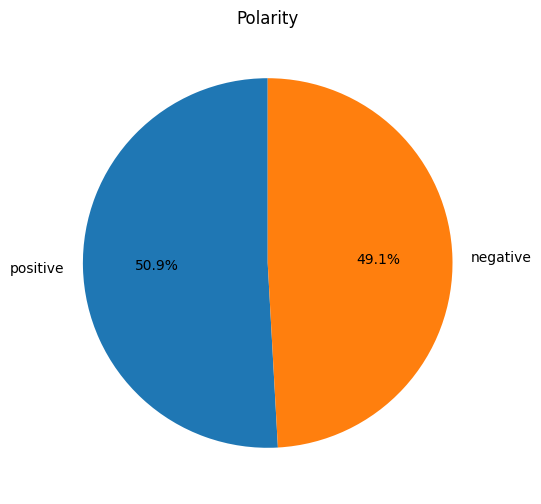

In [17]:
# Menghitung distribusi gender dan menampilkan pie chart untuk visualisasi
polarity_counts = reviews_df["polarity"].value_counts()  # Hitung frekuensi kategori
total = polarity_counts.sum()

plt.figure(figsize=(6, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Polarity')
plt.show()

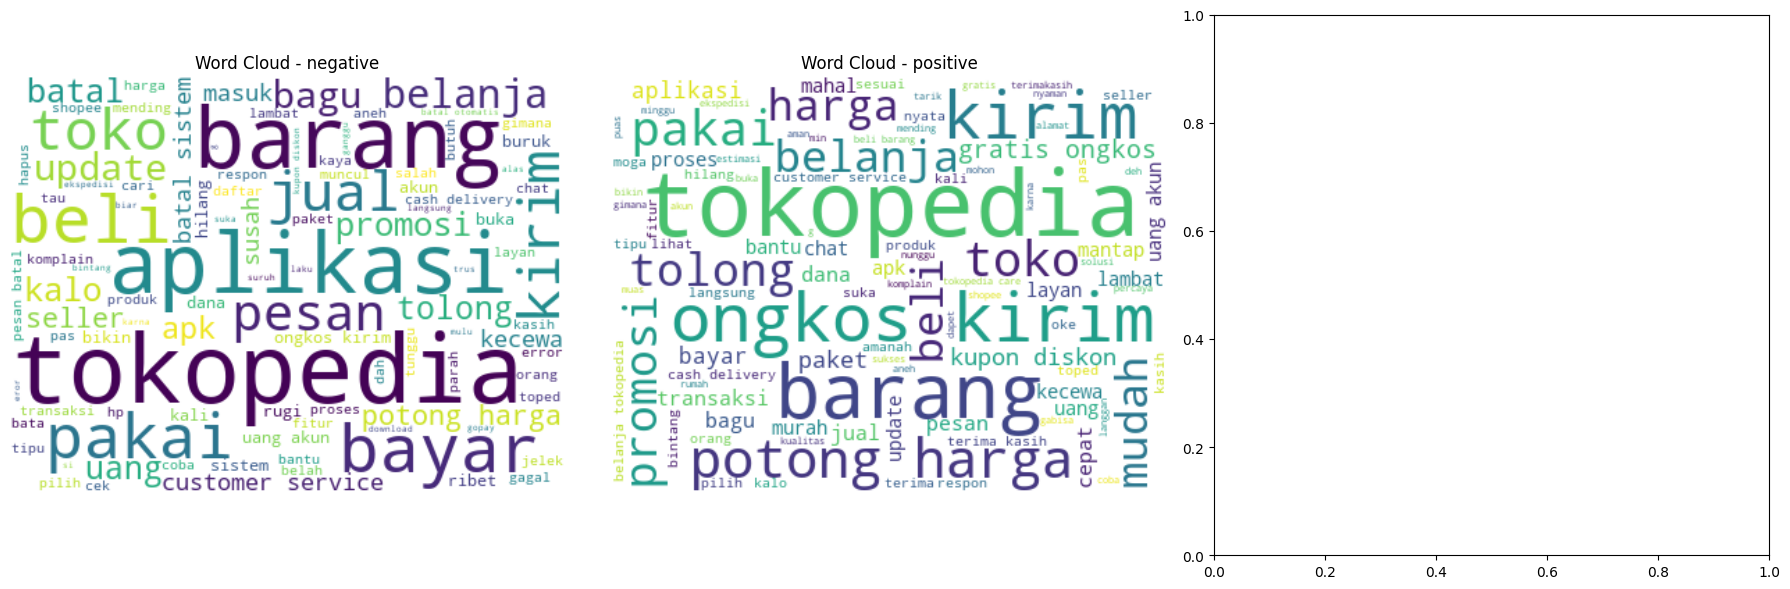

In [18]:
# Membuat figure untuk menampilkan 3 WordCloud
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# Looping untuk setiap kategori polarity
for i, (polarity, group) in enumerate(reviews_df.groupby("polarity")):
    # Gabungkan seluruh teks dari content dalam kategori polarity tertentu
    text = " ".join(group["text_akhir"].dropna())  # Hapus NaN jika ada
    
    # Membuat WordCloud dari semua teks
    wordcloud = WordCloud(width=400, height=300, background_color="white", colormap="viridis",
                          max_words=100, contour_color="black").generate(text)
    
    # Menampilkan WordCloud
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")  # Menghilangkan sumbu
    axes[i].set_title(f"Word Cloud - {polarity}")  # Judul berdasarkan polarity

plt.tight_layout()  # Supaya tata letak rapi
plt.show()

# Data Splitting

In [19]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = reviews_df['text_akhir']
y = reviews_df['polarity']
 
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)
 
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# Menampilkan hasil ekstraksi fitur
features_df
 
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modeling

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon
    'max_depth': [10, 20, None],      # Kedalaman pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4]     # Minimum sampel dalam leaf
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train.toarray(), y_train)

best_rf = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)


Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [21]:
from sklearn.ensemble import RandomForestClassifier
 
# Membuat objek model Random Forest
random_forest = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_leaf=1, min_samples_split=10, max_depth=None)
 
# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())
 
# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)
 
# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.966852886405959
Random Forest - accuracy_test: 0.8110119047619048


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

    negative       0.82      0.79      0.81       336
    positive       0.80      0.83      0.81       336

    accuracy                           0.81       672
   macro avg       0.81      0.81      0.81       672
weighted avg       0.81      0.81      0.81       672

